# Signal Subspace Projections (SSP) for removing artefacts

`
Authors:
Alexandre Gramfort
`

License: BSD (3-clause)

In [2]:
import numpy as np

import mne
from mne.datasets import sample
from mne.utils import set_log_level

In [3]:
# SSP (projection) related functionality
from mne.preprocessing import compute_proj_ecg, compute_proj_eog
from mne.preprocessing import create_ecg_epochs, create_eog_epochs

In [4]:
set_log_level('warning')  # we don't want to see all loging outputs today

In [5]:
# getting some data ready
# data_path = sample.data_path()

data_path = '/Users/alex/mne_data/MNE-sample-data'

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname, preload=True)

# Let's work only with MEG data with the EOG channel(s)
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=True,
                           stim=True, exclude='bads')

raw.pick_channels([raw.ch_names[k] for k in picks_meg])  # select MEG channels only
raw.filter(1, 45, n_jobs=2)  # note the n_jobs=2 to run filtering in parallel !

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 315 x 41700 (277.7 sec), ~103.7 MB, data loaded>

# Before fitting models let's look at what we want to get rid off

First ECG

What is the order of magnitude of the average artefact?

Do we see different spatial patterns?

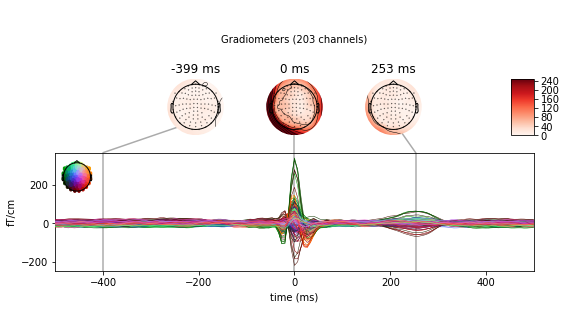

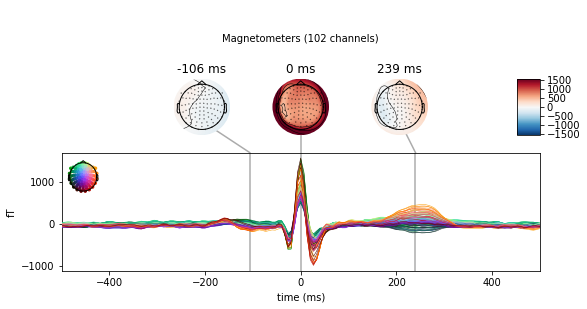

In [6]:
%matplotlib inline 
reject = dict(mag=4e-12, grad=4000e-13)  # don't fit on crazy environmental artefacts
ecg_average = create_ecg_epochs(raw, reject=reject).average()
ecg_average.plot_joint();

And now EOG

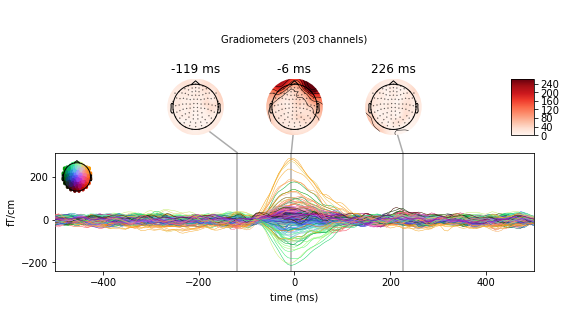

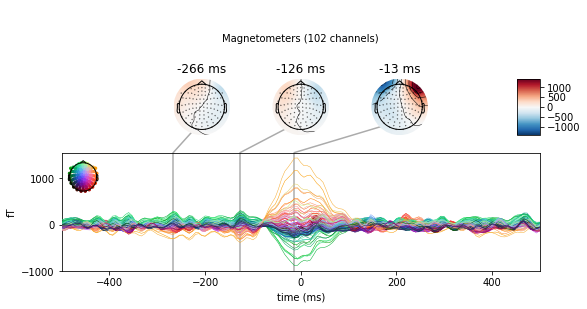

In [7]:
reject = dict(mag=4e-12, grad=4000e-13)  # don't fit on crazy environmental artefacts
eog_average = create_eog_epochs(raw, reject=reject).average()
eog_average.plot_joint();

# Compute SSP projection vectors

First for ECG

In [7]:
compute_proj_ecg?

In [8]:
projs, events = compute_proj_ecg(raw, n_grad=1, n_mag=1, average=True)
print(projs)

[<Projection  |  PCA-v1, active : False, n_channels : 102>, <Projection  |  PCA-v2, active : False, n_channels : 102>, <Projection  |  PCA-v3, active : False, n_channels : 102>, <Projection  |  Average EEG reference, active : False, n_channels : 60>, <Projection  |  ECG-planar--0.200-0.400-PCA-01, active : False, n_channels : 203>, <Projection  |  ECG-axial--0.200-0.400-PCA-01, active : False, n_channels : 102>]


In [9]:
ecg_projs = projs[-2:]

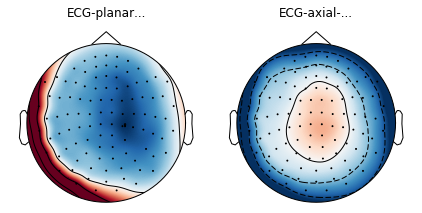

In [10]:
mne.viz.plot_projs_topomap(ecg_projs);

Now for EOG

In [11]:
projs, events = compute_proj_eog(raw, n_grad=1, n_mag=1, average=True)
print(projs)

[<Projection  |  PCA-v1, active : False, n_channels : 102>, <Projection  |  PCA-v2, active : False, n_channels : 102>, <Projection  |  PCA-v3, active : False, n_channels : 102>, <Projection  |  Average EEG reference, active : False, n_channels : 60>, <Projection  |  EOG-planar--0.200-0.200-PCA-01, active : False, n_channels : 203>, <Projection  |  EOG-axial--0.200-0.200-PCA-01, active : False, n_channels : 102>]


In [12]:
eog_projs = projs[-2:]

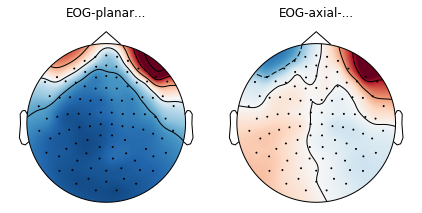

In [13]:
mne.viz.plot_projs_topomap(eog_projs);

### Apply projections

In [14]:
raw.info['projs'] += eog_projs + ecg_projs

In [15]:
events = mne.find_events(raw, stim_channel='STI 014')
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)  # this can be highly data dependent
event_id = [1]

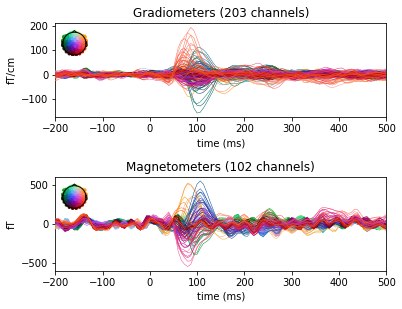

/Users/alex/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [16]:
epochs_no_proj = mne.Epochs(raw, events, event_id, tmin=-0.2,
                            tmax=0.5, proj=False,
                            baseline=(None, 0), reject=reject)
epochs_no_proj.average().plot(spatial_colors=True);

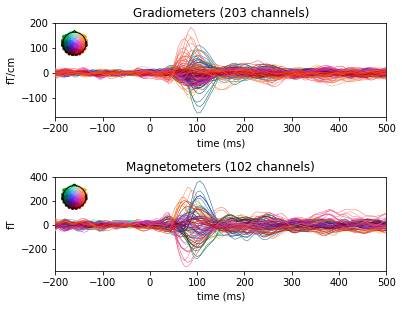

/Users/alex/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [18]:
epochs_proj = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, proj=True,
                         baseline=(None, 0), reject=reject)
epochs_proj.average().plot(spatial_colors=True);